In [59]:
#Import libraries
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)


TF version: 2.10.0
TF Hub version: 0.12.0


In [60]:
unique_breeds = []

for folders in os.listdir(r"C:\Users\Artsy\Desktop\Dog_Breed_Categorization\db_images\images\Images"):
    breed = "".join(folders.split("-")[1:])
    unique_breeds.append(breed)
    
# Converts to sorted ndarray
unique_breeds = np.array(sorted(unique_breeds))
len(unique_breeds), unique_breeds[:10]

(8,
 array(['Bernese_mountain_dog', 'Chihuahua', 'Old_English_sheepdog',
        'Pomeranian', 'Rhodesian_ridgeback', 'Samoyed', 'golden_retriever',
        'pug'], dtype='<U20'))

In [61]:
IMG_SIZE = 224
BATCH_SIZE = 10

#Image Data Pipeline Function
def image_data_pipeline(path, augment=False, img_size=IMG_SIZE, batch_size=BATCH_SIZE, test_data=False, seed=42):
#     """
#     Reads images from path, and splits them into training and validation sets
#     Create batches of data out of (image x) and (label y) pairs.
#     Returns two data batches training_batch and validation_batch.

#     Also accepts test data as input (no labels).
#     """
    
    # Function for retrieving data
    def retrieve_data_from_path(path, test_data=False):
        filenames = []
        # Test data image retrieval (not separated per class)
        if test_data:
            for files in os.listdir(path):
                filenames.append(f"{path}/{files}")
            return np.array(filenames)
        
        # Train and val data image retrieval
        else:
            for folders in os.listdir(path):
                for files in os.listdir(f"{path}/{folders}"):
                    filenames.append(f"{path}/{folders}/{files}")
            filenames = np.array(filenames)
            np.random.shuffle(filenames)
            labels = np.array(["".join(name.split('/')[-2].split("-")[1:]) for name in filenames])
            unique_breeds = np.unique(labels)
            boolean_labels = np.array([label == unique_breeds for label in labels]).astype(int)
            return filenames, boolean_labels

    #Function for preprocessing
    def process_image(filename, img_size=IMG_SIZE):
        #read image
        image = tf.io.read_file(filename)

        #turn jpeg to numerical Tensor with 3 color channels (RGB)
        image = tf.image.decode_jpeg(image, channels=3)

        #Convert colour channels values 0-255 to 0-1 values.
        #This is a normalization process to make process more efficient.
        image = tf.image.convert_image_dtype(image, tf.float32)

        #Resize to (224,224)
        image = tf.image.resize(image, size=[img_size, img_size])

        return image
    
    # Function for data configuration (for performance) 
    def configure_tensor(ds, shuffle=False):
        if shuffle: # For train set
            ds = ds.shuffle(buffer_size=1000) 
        ds = ds.batch(batch_size)
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds
    
    augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode="nearest"),
        tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),
        tf.keras.layers.RandomFlip(mode="horizontal")
    ])
    
    # ----------------------------------------------------------------------------------
    
    # Test data pipeline
    if test_data:
        print(f"Creating test data batches... BATCH SIZE={batch_size}")
        x = retrieve_data_from_path(path, test_data=True)
        x_test = tf.data.Dataset.from_tensor_slices(x).map(process_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        return configure_tensor(x_test)
    
    # Train and validation data pipeline
    else:
        print(f"Creating train & validation data batches... BATCH SIZE={batch_size}")
        x, y = retrieve_data_from_path(path)
        x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=seed)
        x_train = tf.data.Dataset.from_tensor_slices(x_train).map(process_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        x_valid = tf.data.Dataset.from_tensor_slices(x_valid).map(process_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        if augment:
            x_train = x_train.map(augmentation, num_parallel_calls=tf.data.experimental.AUTOTUNE)
            x_valid = x_valid.map(augmentation, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        y_train = tf.data.Dataset.from_tensor_slices(y_train)
        y_valid = tf.data.Dataset.from_tensor_slices(y_valid)
        train_data = tf.data.Dataset.zip((x_train, y_train)) 
        valid_data = tf.data.Dataset.zip((x_valid, y_valid)) 
        return configure_tensor(train_data, shuffle=True), configure_tensor(valid_data)

In [62]:
path = (r"C:\Users\Artsy\Desktop\Dog_Breed_Categorization\db_images\images\Images")
train_data, valid_data = image_data_pipeline(path)
train_data.element_spec, valid_data.element_spec

Creating train & validation data batches... BATCH SIZE=10


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 8), dtype=tf.int32, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 8), dtype=tf.int32, name=None)))

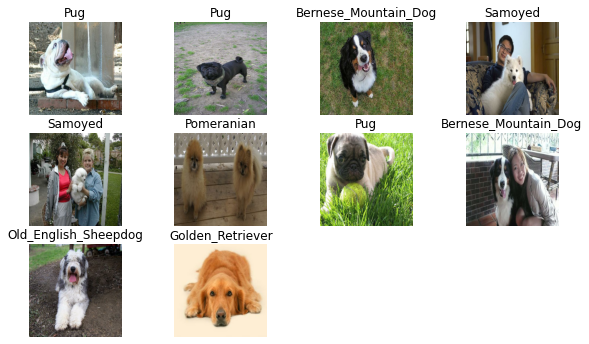

In [63]:
def show_batch(image_batch, label_batch):
  fig = plt.figure(figsize=(10,16))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(8,4,n+1)
      plt.imshow(image_batch[n])
      plt.title(unique_breeds[label_batch[n]==1][0].title(), fontsize=12)
      plt.axis('off')
    
image_batch, label_batch = next(train_data.as_numpy_iterator())
show_batch(image_batch, label_batch)

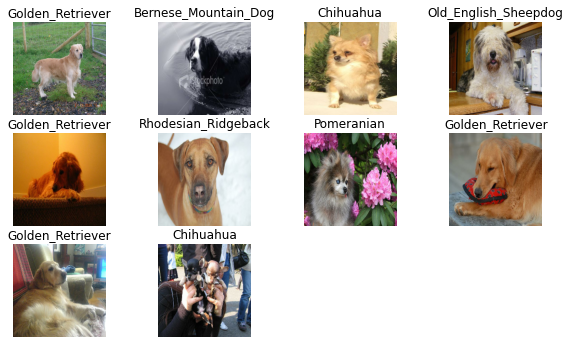

In [64]:
valid_image, valid_label = next(valid_data.as_numpy_iterator())
show_batch(valid_image, valid_label)

In [65]:
#setup input shape into the model
INPUT_SHAPE = [None,IMG_SIZE, IMG_SIZE, 3] #batch, height, width, colour channel

#setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

#setup model URL from Tensorflow HUB
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5"

In [66]:
# Extract Pre-trained base Model and freeze the layers
base_model = hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5")
base_model.trainable = False
len(base_model.trainable_variables) # Shows that its frozen

0

In [67]:
# Setup Layers
model = tf.keras.Sequential([
    base_model, # Layer 1 (Input Layer)
    tf.keras.layers.Dense(units=512, activation="relu"), # Hidden Layer   
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=256, activation="relu"), # Hidden Layer       
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=OUTPUT_SHAPE, activation="softmax") # Layer 4 (Output Layer)       
])


# Compiling the model
base_learning_rate = 0.0001
model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
      metrics =["accuracy"]
)

# Build Model
model.build(INPUT_SHAPE)
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              4226432   
                                                                 
 dense_6 (Dense)             (None, 512)               655872    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 5,015,688
Trainable params: 789,256
Non

In [68]:
len(model.trainable_variables)

6

In [69]:
def create_model_checkpoint(dir, suffix=None):
    modeldir = os.path.join(dir, "Models",
                          datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%s"))
    
    model_path = modeldir + "-" + suffix
    print(f"Model will be saved to `{model_path}`")
    return tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_accuracy',save_best_only=True)

In [70]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=10)

In [71]:
init_loss, init_acc = model.evaluate(valid_data)

4/4 [==============================] - 2s 182ms/step - loss: 2.0844 - accuracy: 0.1875


In [72]:
# Metrics before training (very poor performance)
print("initial loss: {:.2f}".format(init_loss))
print("initial accuracy: {:.2f}".format(init_acc))

initial loss: 2.08
initial accuracy: 0.19


In [73]:
# EPOCHS
NUM_EPOCHS = 3

# Create callback
#checkpoint = create_model_checkpoint("Notebook_Outputs", "MobileNetV3_100_Adam_20580")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=10)

# Model Training
model_history = model.fit(x=train_data,
                    epochs=NUM_EPOCHS,
                    validation_data=valid_data,
                    validation_freq=1,
                    #callbacks=[early_stopping, checkpoint],
                    callbacks=[early_stopping],
                )

Epoch 1/3
13/13 [==============================] - 14s 316ms/step - loss: 1.8689 - accuracy: 0.2891 - val_loss: 1.6410 - val_accuracy: 0.5312
Epoch 2/3
13/13 [==============================] - 4s 319ms/step - loss: 1.2657 - accuracy: 0.7656 - val_loss: 1.2785 - val_accuracy: 0.7188
Epoch 3/3
13/13 [==============================] - 4s 325ms/step - loss: 0.8342 - accuracy: 0.9062 - val_loss: 0.9749 - val_accuracy: 0.8750


In [74]:
plot_learning_curves(model_history_augment)

NameError: name 'plot_learning_curves' is not defined